# 共起分析とネットワーク図による可視化

## 共起
共起(co-occurrence)とは，任意の文書において，単語Aと単語Bが同時に出現することをいう。

例えば
```
桃太郎/は/鬼退治/に/出掛けた
```
という文章の場合，共起ペアは
```
(桃太郎, は), (桃太郎, 鬼退治), (桃太郎, に), (桃太郎, 出掛けた)
(は, 鬼退治), (は, に), (は, 出掛けた),(鬼退治, に),
(鬼退治, 出掛けた), (に, 出掛けた)
```
となる。

## 共起する単語をノードとするネットワークの構築
処理の流れは以下のとおり：
1. データ読み込み
1. 各ツイートについて次の処理を行う
    1. ツイートをトークン集合に変換 (MeCab の利用)
    1. トークン集合から CFD を取得
1. 各ツイートの CFD を積み上げる
1. ネットワーク図の作成

read dataset ....
get cfd ....


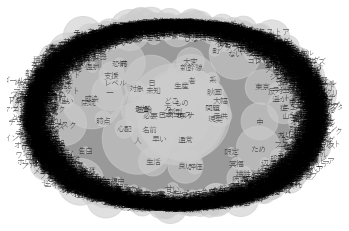

In [27]:
import nltk
import MeCab
import sys

# テキストファイル読み込み
def read_documents(filename):
    with open(filename, mode='rt', encoding='utf-8') as f:
        docs = []

        for line in f.readlines():
            # 何故か分からないが，id, retweet_count 等が含まれないテキストのみの行が存在する
            try:
                status_id, retweet_count, favorite_count, text = line.rstrip('\n').split('\t')
            except ValueError:
                pass

            status_id = int(status_id)
            retweet_count = int(retweet_count)
            favorite_count = int(favorite_count)

            # URL を含むツイートを排除（超簡易版の実装）
            if "http" in text:
                continue

            docs.append(text)
            
    return docs

# 文書からトークン集合への変換
def doc2token(doc):
    # MeCabの準備
    tagger = MeCab.Tagger()
    tagger.parse('')
    node = tagger.parseToNode(doc)

    # 名詞・形容詞を取り出す
    stop_words = ['*', 'さん', 'ちゃん', 'あれ', 'ただ', 'もん',
                 'ここ', 'ん', 'あちゃん', 'わけ', 'こと', 'それ',
                 'みたい', 'よう', 'せい']
    word_list = []
    while node:
        word_type = node.feature.split(',')[0]
        kihon = node.feature.split(',')[6]
        if word_type in ['形容詞', '名詞']:
            if kihon not in stop_words:
                word_list.append(kihon)

        node = node.next
    
    return word_list

# トークン集合から条件付き頻度分布を得る
def get_cfd(tokens):
    corpus = nltk.Text(tokens)
    ngrams = nltk.ngrams(corpus, 2)
    cfd = nltk.ConditionalFreqDist(ngrams)
    return cfd

# データ読み込み
print("read dataset ....", file=sys.stderr)
docs = read_documents(r'C:\Users\yoshi\Dropbox\ExpSSE3\Tweets\20200612_MERS.txt')

# CFD の取得・・・相応に計算時間がかかる
print("get cfd ....", file=sys.stderr)
cfd = get_cfd(doc2token(docs[0]))
counter = 1
for doc in docs[1:1001]:
    # print("{}/{}".format(counter, len(docs)))
    counter += 1
    
    tokens = doc2token(doc)
    cfd += get_cfd(tokens)

# CFD を共起ペアのリストへ置き換える
result = []
for key, values in cfd.items():
    for word in values:
        # print(key, word)
        result.append((key, word))

# ネットワーク図の作成
print("build network ....", file=sys.stderr)
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph() # 無向グラフ
G.add_edges_from(result) # エッジの追加

node_size = [ d * 20 for (n,d) in G.degree() ]
pos = nx.spring_layout(G, k=1.2)
nx.draw_networkx(G, pos=pos, node_color='#CCCCCC', edge_color='#999999', alpha=0.6,
                 font_family="Yu Gothic", font_size=8, node_size=node_size)

plt.axis('off')
# plt.savefig("./collocation_network.png")
plt.show()

### 得られた CFD の中身を見てみる

In [28]:
cfd['コロナ']

FreqDist({'ウイルス': 943, '感染': 6, 'コロナ': 5, '禍': 4, 'の': 4, '新型': 4, '対策': 4, '時代': 4, '人': 4, 'ウィルス': 3, ...})

In [29]:
cfd['コロナ']['ウイルス']

943

### 共起ペアの出現頻度による枝刈り
上記のネットワーク図は明らかに過密であり，解釈困難である。
その原因のひとつとして単語数（種類数）が大きすぎることが考えられる。

実際に単語数を数えた結果，以下のとおりとなった。

In [34]:
len(cfd)

3952

ネットワーク図が過密となる，もうひとつの原因は「全ての共起」を描くことにある。
重要な共起は繰り返し（すなわち，数多く）出現することから，共起頻度により枝刈りする手が考えられる。

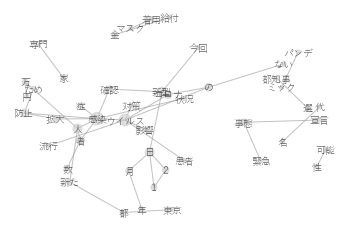

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

# CFD を「共起ペア ＆ 出現頻度」の辞書に組み替える
# 例：{(コロナ, 感染):120, (コロナ, 陽性):30, ....}
result = dict()
# result = dict()
for key, values in cfd.items():
    for word in values:
        # print(key, word)
        result[(key, word)] = cfd[key][word]

# ネットワーク図の作成
G = nx.Graph() # 無向グラフ

for u, v in result:
    # threshold 以上の頻度を有するエッジを追加（枝刈り）
    threshold = 10
    if result[(u,v)] >= threshold:
        # print(u, v, result[(u,v)])
        G.add_edge(u, v, weight=result[(u, v)])

node_size = [ d * 20 for (n,d) in G.degree() ]
pos = nx.spring_layout(G, k=1.2)
nx.draw_networkx(G, pos=pos, node_color='#CCCCCC', edge_color='#999999', alpha=0.6,
                 font_family="Yu Gothic", font_size=10, node_size=node_size)

plt.axis('off')
plt.savefig("collocation_network.png")
plt.show()